In [1]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("..") 
from gcforest.gcforest import GCForest
import cmaes as cma

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 数据以及参数

In [2]:
random_seed = 42

其余基本模型的参数都是sklearn默认的

设置深度森林参数：最大层数20，连续5层没有效果（WF1）提升则停止，每一层：4个随机森林，3个决策树，1个逻辑回归

In [3]:
path = os.getcwd()+'/../data/20122018freshwater_four_feature.csv'
data = pd.read_csv(path, na_values = np.nan)

In [4]:
# training/valid/test: 0.6/0.2/0.2, 各数据集划分的时候要注意
X = data.drop(['本周水质'], axis=1).values # Series
y = data['本周水质'].values-1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                       stratify = y, random_state = random_seed)
# Z-score
clean_pipeline = Pipeline([('imputer', preprocessing.Imputer(missing_values='NaN',strategy="median")),
                           ('std_scaler', preprocessing.StandardScaler()),])
X_train = clean_pipeline.fit_transform(X_train)
X_test = clean_pipeline.fit_transform(X_test)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                       stratify = y_train, random_state = random_seed)

# 载入训练好的模型

In [5]:
models = [
    "LogisticRegression",
    "LinearDiscriminantAnalysis",
    "SVC",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
    "GaussianNB",
    "KNeighborsClassifier",
    "RandomForestClassifier",
    "ExtraTreesClassifier",
    "GCForest"
]


y_pred_proba_all = []

import pickle
i=0
for model in models:
    model_name = model
    model_path = "../pkl/CE_" + model_name + ".pkl"
    with open(model_path, "rb") as f:
        models[i] = pickle.load(f)
    y_pred_proba = models[i].predict_proba(X_valid)
    y_pred = models[i].predict(X_valid)
    print("%s, valid weighted f1 score:%f" %(model_name, f1_score(y_valid, y_pred, average="weighted")))
    y_pred_proba_all.append(y_pred_proba)
    i = i+1

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression, valid weighted f1 score:0.618051
LinearDiscriminantAnalysis, valid weighted f1 score:0.569881
SVC, valid weighted f1 score:0.886775
DecisionTreeClassifier, valid weighted f1 score:0.987514
ExtraTreeClassifier, valid weighted f1 score:0.895863
GaussianNB, valid weighted f1 score:0.812976
KNeighborsClassifier, valid weighted f1 score:0.891579
RandomForestClassifier, valid weighted f1 score:0.994051
ExtraTreesClassifier, valid weighted f1 score:0.973277


[ 2019-05-15 19:59:49,564][cascade_classifier.transform] X_groups_test.shape=[(6723, 4)]
[ 2019-05-15 19:59:49,565][cascade_classifier.transform] group_dims=[4]
[ 2019-05-15 19:59:49,566][cascade_classifier.transform] X_test.shape=(6723, 4)
[ 2019-05-15 19:59:49,567][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(6723, 4)
[ 2019-05-15 19:59:49,740][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(6723, 52)
[ 2019-05-15 19:59:49,929][cascade_classifier.transform] [layer=2] look_indexs=[0], X_cur_test.shape=(6723, 52)
[ 2019-05-15 19:59:50,105][cascade_classifier.transform] [layer=3] look_indexs=[0], X_cur_test.shape=(6723, 52)
[ 2019-05-15 19:59:50,270][cascade_classifier.transform] [layer=4] look_indexs=[0], X_cur_test.shape=(6723, 52)
[ 2019-05-15 19:59:50,452][cascade_classifier.transform] [layer=5] look_indexs=[0], X_cur_test.shape=(6723, 52)
[ 2019-05-15 19:59:50,623][cascade_classifier.transform] X_groups_test.shape=[(6723, 4)]

GCForest, valid weighted f1 score:0.994052


深度森林训练结果：4层不再有效果提升

opt_layer_num=4, weighted_f1_train=99.45%, weighted_f1_test=97.66%

60%训练集，20%的测试集仅用做展示

# 验证

In [6]:
y_pred_proba_all = np.asarray(y_pred_proba_all)
np.save("../npy/y_pred_proba_all.npy", y_pred_proba_all)

In [7]:
# 直接载入各个模型在验证集的概率向量，用于训练CMAES
# y_pred_proba_all = np.load("../npy/y_pred_proba_all.npy")

In [8]:
es = cma.CMAEvolutionStrategy(10 * [0], 0.5)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1004271, Wed May 15 19:59:51 2019)


In [9]:
# help(cma)
# help(es)

In [10]:
# score = "f1_weighted"
score = "accuracy"
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [cma.ff.water_ensemble(x, y_pred_proba_all, y_valid, metric=score) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -9.930090733303585e-01 1.0e+00 4.42e-01  4e-01  4e-01 0:00.0
    2     20 -9.939015320541424e-01 1.1e+00 4.30e-01  4e-01  4e-01 0:00.1
    3     30 -9.939015320541424e-01 1.2e+00 4.24e-01  4e-01  4e-01 0:00.1
WARNING (iteration=19):  flat fitness (f=-0.994199, sigma=4.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=19):  flat fitness (f=-0.994199, sigma=4.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=20):  flat fitness (f=-0.994199, sigma=4.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute t

WARNING (iteration=43):  flat fitness (f=-0.994199, sigma=1.90e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=43):  flat fitness (f=-0.994199, sigma=1.90e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=44):  flat fitness (f=-0.994199, sigma=1.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=44):  flat fitness (f=-0.994199, sigma=1.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=4

WARNING (iteration=45):  flat fitness (f=-0.994199, sigma=1.90e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
termination on tolfun=1e-11
termination on tolfunhist=1e-12
termination on flat fitness=please (re)consider how to compute the fitness more elaborately if sigma=1.90e-01 is large
final/bestever f-value = -9.941990e-01 -9.941990e-01
incumbent solution: [-0.20295417  0.16338229 -2.027465   -0.10395902 -3.18194828 -0.51058618
 -0.27206412  0.6093874  ...]
std deviations: [0.16690855 0.14334279 0.1628791  0.1374395  0.21323913 0.16861833
 0.13661652 0.17827592 ...]


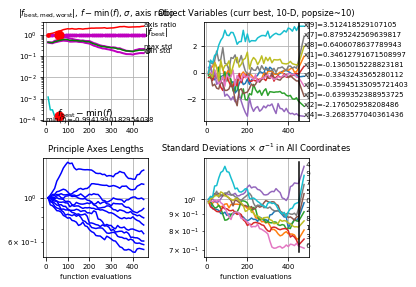

In [11]:
es.result_pretty()  # pretty print result
cma.plot()

## 得到10个基模型的权重

In [12]:
# weights = np.exp(es.result.xbest)/np.sum(np.exp(es.result.xbest))
weights = np.load("../npy/cmaes_weights.npy")  # 载入保存的权重，直接载入仅在懒得训练CMAES时使用或者想得到固定的结果

# weights of each base models
print("CMAES weights", weights)
# np.save("../npy/cmaes_weights.npy", weights) # 保存结果

CMAES weights [0.08997547 0.01895907 0.01965637 0.16923322 0.05871959 0.08640672
 0.03309945 0.00781195 0.0814782  0.43465996]


# 测试

代入权重，在3个集合上计算ACC和F1

- 训练集（总样本数量的60%）X_train2
- 验证集（总样本数量的20%，调参数，用CMAES得到权重）X_valid
- 测试集（总样本数的20%）X_test
- 各模型稳定性基于交叉验证，在除测试集外的80%上做5折 X_train

### ACC

In [13]:
# 取训练好的模型
for model in models:
    model_name = model.__class__.__name__
    train_pred = model.predict(X_train2)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    print("=================" + model_name + "=================")
    train_cm = confusion_matrix(y_train2, train_pred)
    valid_cm = confusion_matrix(y_valid, valid_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    i=0
    train_acc_all = np.zeros(6)
    for c in train_cm:
        train_acc_all[i] = c[i]/np.sum(c)
        print("%d train_acc: %.2f" %(i+1, 100*train_acc_all[i]))
        i=i+1
    print("average: %.2f" % (100*np.mean(train_acc_all)))
    i=0
    valid_acc_all = np.zeros(6)
    for c in valid_cm:
        valid_acc_all[i] = c[i]/np.sum(c)
        print("%d valid_acc: %.2f" %(i+1, 100*valid_acc_all[i]))
        i=i+1
    print("average: %.2f" % (100*np.mean(valid_acc_all)))
    i=0
    test_acc_all = np.zeros(6)
    for c in test_cm:
        test_acc_all[i] = c[i]/np.sum(c)
        print("%d test_acc: %.2f" %(i+1, 100*test_acc_all[i]))
        i=i+1
    print("average: %.2f" % (100*np.mean(test_acc_all)))


# - 计算CE（1-10）

population_best_weight = weights

classifier_num = 10

# 所有学习器都输出概率向量，最后投票
y_train_pred_proba_all = []
y_valid_pred_proba_all = []
y_test_pred_proba_all = []

# 取训练好的模型，计算各模型”验证集“上输出概率向量
for model in models:
    train_pred_proba = model.predict_proba(X_train2)
    valid_pred_proba = model.predict_proba(X_valid)
    test_pred_proba = model.predict_proba(X_test)
    y_train_pred_proba_all.append(train_pred_proba)
    y_valid_pred_proba_all.append(valid_pred_proba)
    y_test_pred_proba_all.append(test_pred_proba)
    
y_train_pred_ensemble_proba = np.zeros((len(y_train2), 6)) # 初始化集成器概率向量
y_valid_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 初始化集成器概率向量
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 初始化集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_train_pred_ensemble_proba += y_train_pred_proba_all[k] * population_best_weight[k]
    y_valid_pred_ensemble_proba += y_valid_pred_proba_all[k] * population_best_weight[k]
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * population_best_weight[k]
y_train_pred_ensemble = np.argmax(y_train_pred_ensemble_proba, axis=1)
y_valid_pred_ensemble = np.argmax(y_valid_pred_ensemble_proba, axis=1)
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1)

# 计算各水质等级的得分
print("=================CMAES=================")
train_cm = confusion_matrix(y_train2, y_train_pred_ensemble)
valid_cm = confusion_matrix(y_valid, y_valid_pred_ensemble)
test_cm = confusion_matrix(y_test, y_test_pred_ensemble)
i=0
train_acc_all = np.zeros(6)
for c in train_cm:
    train_acc_all[i] = c[i]/np.sum(c)
    print("%d train_acc: %.2f" %(i+1, 100*train_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(train_acc_all)))
i=0
valid_acc_all = np.zeros(6)
for c in valid_cm:
    valid_acc_all[i] = c[i]/np.sum(c)
    print("%d valid_acc: %.2f" %(i+1, 100*valid_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(valid_acc_all)))
i=0
test_acc_all = np.zeros(6)
for c in test_cm:
    test_acc_all[i] = c[i]/np.sum(c)
    print("%d test_acc: %.2f" %(i+1, 100*test_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(test_acc_all)))


=================LogisticRegression=================
1 train_acc: 3.08
2 train_acc: 99.21
3 train_acc: 57.22
4 train_acc: 45.05
5 train_acc: 0.00
6 train_acc: 77.02
average: 46.93
1 valid_acc: 3.07
2 valid_acc: 99.13
3 valid_acc: 58.50
4 valid_acc: 45.21
5 valid_acc: 0.00
6 valid_acc: 78.79
average: 47.45
1 test_acc: 5.74
2 test_acc: 99.51
3 test_acc: 55.17
4 test_acc: 48.08
5 test_acc: 0.00
6 test_acc: 80.19
average: 48.11
=================LinearDiscriminantAnalysis=================
1 train_acc: 0.00
2 train_acc: 99.90
3 train_acc: 38.08
4 train_acc: 50.62
5 train_acc: 28.33
6 train_acc: 44.57
average: 43.58
1 valid_acc: 0.00
2 valid_acc: 99.85
3 valid_acc: 38.49
4 valid_acc: 51.42
5 valid_acc: 26.94
6 valid_acc: 45.45
average: 43.69
1 test_acc: 0.00
2 test_acc: 99.92
3 test_acc: 38.58
4 test_acc: 52.83
5 test_acc: 29.97
6 test_acc: 47.32
average: 44.77
=================SVC=================
1 train_acc: 64.64
2 train_acc: 93.62
3 train_acc: 89.20
4 train_acc: 90.07
5 train_acc: 87.35


[ 2019-05-15 20:00:00,810][cascade_classifier.transform] X_groups_test.shape=[(20166, 4)]
[ 2019-05-15 20:00:00,812][cascade_classifier.transform] group_dims=[4]
[ 2019-05-15 20:00:00,813][cascade_classifier.transform] X_test.shape=(20166, 4)
[ 2019-05-15 20:00:00,814][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(20166, 4)


=================KNeighborsClassifier=================
1 train_acc: 84.06
2 train_acc: 96.51
3 train_acc: 93.43
4 train_acc: 94.21
5 train_acc: 85.89
6 train_acc: 94.88
average: 91.50
1 valid_acc: 77.46
2 valid_acc: 93.48
3 valid_acc: 89.31
4 valid_acc: 88.68
5 valid_acc: 70.03
6 valid_acc: 90.44
average: 84.90
1 test_acc: 76.84
2 test_acc: 93.15
3 test_acc: 88.75
4 test_acc: 89.58
5 test_acc: 81.82
6 test_acc: 93.94
average: 87.35
=================RandomForestClassifier=================
1 train_acc: 99.66
2 train_acc: 99.97
3 train_acc: 99.94
4 train_acc: 99.85
5 train_acc: 99.66
6 train_acc: 99.92
average: 99.84
1 valid_acc: 99.18
2 valid_acc: 99.51
3 valid_acc: 99.55
4 valid_acc: 99.27
5 valid_acc: 98.65
6 valid_acc: 99.30
average: 99.24
1 test_acc: 99.39
2 test_acc: 97.55
3 test_acc: 98.01
4 test_acc: 96.98
5 test_acc: 93.27
6 test_acc: 98.83
average: 97.34
=================ExtraTreesClassifier=================
1 train_acc: 100.00
2 train_acc: 100.00
3 train_acc: 100.00
4 train_acc

[ 2019-05-15 20:00:01,229][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:01,720][cascade_classifier.transform] [layer=2] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:02,164][cascade_classifier.transform] [layer=3] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:02,614][cascade_classifier.transform] [layer=4] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:03,057][cascade_classifier.transform] [layer=5] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:03,523][cascade_classifier.transform] X_groups_test.shape=[(6723, 4)]
[ 2019-05-15 20:00:03,524][cascade_classifier.transform] group_dims=[4]
[ 2019-05-15 20:00:03,524][cascade_classifier.transform] X_test.shape=(6723, 4)
[ 2019-05-15 20:00:03,526][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(6723, 4)
[ 2019-05-15 20:00:03,683][cascade_classifier.transform] [layer=1] look_indexs=[0],

=================GCForest=================
1 train_acc: 99.66
2 train_acc: 99.95
3 train_acc: 99.83
4 train_acc: 99.97
5 train_acc: 100.00
6 train_acc: 100.00
average: 99.90
1 valid_acc: 99.39
2 valid_acc: 99.51
3 valid_acc: 99.49
4 valid_acc: 99.27
5 valid_acc: 98.99
6 valid_acc: 99.07
average: 99.29
1 test_acc: 99.39
2 test_acc: 97.59
3 test_acc: 98.01
4 test_acc: 96.98
5 test_acc: 93.27
6 test_acc: 99.07
average: 97.38


[ 2019-05-15 20:00:11,424][cascade_classifier.transform] X_groups_test.shape=[(20166, 4)]
[ 2019-05-15 20:00:11,425][cascade_classifier.transform] group_dims=[4]
[ 2019-05-15 20:00:11,426][cascade_classifier.transform] X_test.shape=(20166, 4)
[ 2019-05-15 20:00:11,428][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(20166, 4)
[ 2019-05-15 20:00:11,845][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:12,308][cascade_classifier.transform] [layer=2] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:12,758][cascade_classifier.transform] [layer=3] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:13,196][cascade_classifier.transform] [layer=4] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:13,642][cascade_classifier.transform] [layer=5] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:14,089][cascade_classifier.transform] X_groups_test.shape=[(6

=================CMAES=================
1 train_acc: 100.00
2 train_acc: 99.99
3 train_acc: 99.96
4 train_acc: 100.00
5 train_acc: 100.00
6 train_acc: 100.00
average: 99.99
1 valid_acc: 99.39
2 valid_acc: 99.51
3 valid_acc: 99.49
4 valid_acc: 99.27
5 valid_acc: 98.99
6 valid_acc: 99.07
average: 99.29
1 test_acc: 99.39
2 test_acc: 97.63
3 test_acc: 98.01
4 test_acc: 96.98
5 test_acc: 93.27
6 test_acc: 99.07
average: 97.39


### F1

In [14]:
# 所有学习器都输出概率向量，最后投票
y_train_pred_proba_all = []
y_valid_pred_proba_all = []
y_test_pred_proba_all = []

# 取训练好的模型，计算各模型”验证集“上输出概率向量
for model in models:
    model_name = model.__class__.__name__
    train_pred_proba = model.predict_proba(X_train2)
    valid_pred_proba = model.predict_proba(X_valid)
    test_pred_proba = model.predict_proba(X_test)
    train_pred = model.predict(X_train2)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    print("=================" + model_name + "=================")
    print(classification_report(y_train2, train_pred, digits=4))
    print(classification_report(y_valid, valid_pred, digits=4))
    print(classification_report(y_test, test_pred, digits=4))

    y_train_pred_proba_all.append(train_pred_proba)
    y_valid_pred_proba_all.append(valid_pred_proba)
    y_test_pred_proba_all.append(test_pred_proba)

    
y_train_pred_ensemble_proba = np.zeros((len(y_train2), 6)) # 初始化集成器概率向量
y_valid_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 初始化集成器概率向量
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 初始化集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_train_pred_ensemble_proba += y_train_pred_proba_all[k] * population_best_weight[k]
    y_valid_pred_ensemble_proba += y_valid_pred_proba_all[k] * population_best_weight[k]
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * population_best_weight[k]
y_train_pred_ensemble = np.argmax(y_train_pred_ensemble_proba, axis=1)
y_valid_pred_ensemble = np.argmax(y_valid_pred_ensemble_proba, axis=1)
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1)

# 计算各水质等级的得分
print("=================CMAES=================")

print(classification_report(y_train2, y_train_pred_ensemble, digits=4))
print(classification_report(y_valid, y_valid_pred_ensemble, digits=4))
print(classification_report(y_test, y_test_pred_ensemble, digits=4))

=================LogisticRegression=================
             precision    recall  f1-score   support

          0     0.8654    0.0308    0.0594      1462
          1     0.6703    0.9921    0.8000      7962
          2     0.6432    0.5722    0.6056      5278
          3     0.6217    0.4505    0.5224      3283
          4     0.0000    0.0000    0.0000       893
          5     0.7904    0.7702    0.7802      1288

avg / total     0.6474    0.6662    0.6136     20166

             precision    recall  f1-score   support

          0     0.9375    0.0307    0.0595       488
          1     0.6764    0.9913    0.8042      2655
          2     0.6439    0.5850    0.6130      1759
          3     0.6338    0.4521    0.5277      1095
          4     0.0000    0.0000    0.0000       297
          5     0.7735    0.7879    0.7806       429

avg / total     0.6562    0.6707    0.6181      6723

             precision    recall  f1-score   support

          0     0.9333    0.0574    0.1

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


=================SVC=================
             precision    recall  f1-score   support

          0     0.8607    0.6464    0.7383      1462
          1     0.8850    0.9362    0.9099      7962
          2     0.8812    0.8920    0.8865      5278
          3     0.9375    0.9007    0.9188      3283
          4     0.8914    0.8735    0.8824       893
          5     0.9686    0.9573    0.9629      1288

avg / total     0.8964    0.8964    0.8949     20166

             precision    recall  f1-score   support

          0     0.8509    0.6434    0.7328       488
          1     0.8802    0.9322    0.9054      2655
          2     0.8760    0.8874    0.8817      1759
          3     0.9239    0.8977    0.9106      1095
          4     0.8826    0.7845    0.8307       297
          5     0.9421    0.9487    0.9454       429

avg / total     0.8881    0.8884    0.8868      6723

             precision    recall  f1-score   support

          0     0.7970    0.6516    0.7170       488
 

[ 2019-05-15 20:00:27,738][cascade_classifier.transform] X_groups_test.shape=[(20166, 4)]
[ 2019-05-15 20:00:27,739][cascade_classifier.transform] group_dims=[4]
[ 2019-05-15 20:00:27,740][cascade_classifier.transform] X_test.shape=(20166, 4)
[ 2019-05-15 20:00:27,741][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(20166, 4)


=================ExtraTreesClassifier=================
             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000      1462
          1     1.0000    1.0000    1.0000      7962
          2     1.0000    1.0000    1.0000      5278
          3     1.0000    1.0000    1.0000      3283
          4     1.0000    1.0000    1.0000       893
          5     1.0000    1.0000    1.0000      1288

avg / total     1.0000    1.0000    1.0000     20166

             precision    recall  f1-score   support

          0     0.9619    0.9836    0.9726       488
          1     0.9835    0.9864    0.9850      2655
          2     0.9717    0.9756    0.9736      1759
          3     0.9697    0.9635    0.9666      1095
          4     0.9321    0.8788    0.9047       297
          5     0.9672    0.9627    0.9650       429

avg / total     0.9733    0.9734    0.9733      6723

             precision    recall  f1-score   support

          0     0.8905    0.9836    0

[ 2019-05-15 20:00:28,157][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:28,631][cascade_classifier.transform] [layer=2] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:29,083][cascade_classifier.transform] [layer=3] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:29,527][cascade_classifier.transform] [layer=4] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:29,968][cascade_classifier.transform] [layer=5] look_indexs=[0], X_cur_test.shape=(20166, 52)
[ 2019-05-15 20:00:30,427][cascade_classifier.transform] X_groups_test.shape=[(6723, 4)]
[ 2019-05-15 20:00:30,428][cascade_classifier.transform] group_dims=[4]
[ 2019-05-15 20:00:30,429][cascade_classifier.transform] X_test.shape=(6723, 4)
[ 2019-05-15 20:00:30,430][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(6723, 4)
[ 2019-05-15 20:00:30,586][cascade_classifier.transform] [layer=1] look_indexs=[0],

=================GCForest=================
             precision    recall  f1-score   support

          0     0.9979    0.9966    0.9973      1462
          1     0.9992    0.9995    0.9994      7962
          2     1.0000    0.9983    0.9991      5278
          3     0.9985    0.9997    0.9991      3283
          4     0.9944    1.0000    0.9972       893
          5     1.0000    1.0000    1.0000      1288

avg / total     0.9991    0.9991    0.9991     20166

             precision    recall  f1-score   support

          0     0.9898    0.9939    0.9918       488
          1     0.9970    0.9951    0.9960      2655
          2     0.9938    0.9949    0.9943      1759
          3     0.9927    0.9927    0.9927      1095
          4     0.9833    0.9899    0.9866       297
          5     0.9930    0.9907    0.9918       429

avg / total     0.9941    0.9941    0.9941      6723

             precision    recall  f1-score   support

          0     0.9082    0.9939    0.9491       

人为设定了10个参数的初值x0=10*[0]，sigma0=0.5, 算法包中对sigma0的描述为：

http://cma.gforge.inria.fr/apidocs-pycma/cma.evolution_strategy.CMAEvolutionStrategy.html

> initial standard deviation. The problem variables should have been scaled, such that a single standard deviation on all variables is useful and the optimum is expected to lie within about x0 +- 3*sigma0. See also options scaling_of_variables. Often one wants to check for solutions close to the initial point. This allows, for example, for an easier check of consistency of the objective function and its interfacing with the optimizer. In this case, a much smaller sigma0 is advisable.

CMAES 知乎算法专栏
https://zhuanlan.zhihu.com/p/31193293

In [19]:
# 算法默认参数

cma.CMAOptions.defaults()


{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid',
 'CMA_dampsvec_fac': 'np.Inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utils.eig or pygsl.eigen.eigenvectors',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_mirrormethod': '2  # 0=unconditional, 1=